# Modelling of interventions for TB in prisons

##### Alliance meeting Paraguay EUSAT-RCS consortium, 2024

In [9]:
# Load necessary libraries
library(deSolve)
library(gridExtra)
library(ggplot2)
library(reshape)
library(R6)
library(vscDebugger)


ERROR: Error in library(reshape): there is no package called 'reshape'


In [10]:
# Model Parameters
T.lfx    <- 72              # Life expectancy
T.dur    <- 3               # Duration of infectious period
mu       <- 1/T.lfx         # Background mortality rate
mu_tb    <- 0.5*1/T.dur     # TB mortality rate
fast     <- 0.1             # Fraction fast progressing to active TB
imm      <- 0.5             # Infectiousness decline (partial immunity)
relapse  <- 0.005           # Relapse rate
phi      <- 0.0019          # Incarceration rate 
rho      <- 0.2             # release rate (1/mean term time) 

#Community params
beta     <- 5              # Transmission rate per capita
break_in <- 0.1*1/T.lfx     # Transition rate from latent to active disease
selfcure <- 0.5*1/T.dur                # Rate of spontaneous cure

#Prison params
beta_p     <- 5              # Transmission rate per capita
break_in_p <- 0.1*1/T.lfx     # Transition rate from latent to active disease
selfcure_p <- 0.5*1/T.dur                # Rate of spontaneous cure



In [15]:
# Load the R functions for TB transmission in prisons and for analysisng interventions
source('R/TB_prison.R')
source('R/get_intervention.R')

In [16]:
t.intervention <- 400      # years of simulation
t.scale        <- 3        # Scaling up time of interventions
times <- seq(0, t.intervention, by = 1)          # time scale

In [17]:
# Create
params <- c(
    break_in = break_in,
    break_in_p = break_in_p,
    selfcure = selfcure, 
    selfcure_p = selfcure_p, 
    mu = mu, 
    mu_tb = mu_tb,
    beta = beta,
    beta_p = beta_p, 
    fast = fast, 
    imm = imm, 
    relapse = relapse) 

# Initial Conditions
N  <- 1                  # Total population equal to unity 
I0 <- 1e-6                 # TB seed at time 0

xstart <- data.frame(
                     U = N-I0,
                     L = 0,
                     I = I0,  
                     R = 0,
                     Up = 0,
                     Lp = 0,
                     Ip = 0,  
                     Rp = 0,
                     Incidence = 0, 
                     Irecent = 0, 
                     Iremote = 0,
                     Incidence_p = 0, 
                     Irecent_p = 0, 
                     Iremote_p = 0)            

DLSODA-  At T (=R1), too much accuracy requested  
      for precision of machine..  See TOLSF (=R2) 
In above message, R1 = 0.001, R2 = nan
 


Warning message in lsoda(y, times, func, parms, ...):
"Excessive precision requested.  scale up `rtol' and `atol' e.g by the factor 10"
Warning message in lsoda(y, times, func, parms, ...):
"Returning early. Results are accurate, as far as they go"
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


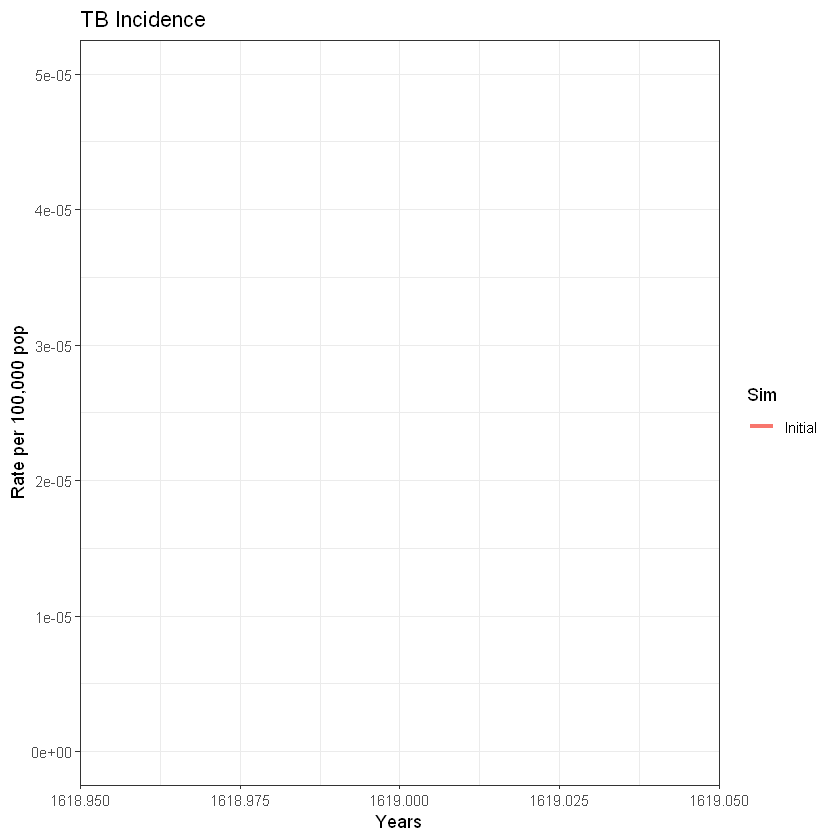

In [19]:
out  <- get_intervention(xstart, params, NA, times, NA, NA, TB_prison,
"Initial", NA) 

# plot
out$lines1

In [ ]:
# :::::: FILL IN THE MISSING VALUES HERE 

Inc.country    <- 210  # TB incidence per 100,000 (including TB/HIV) 
country.name   <- "Kenya" # e.g., "Sierra Leone"
params["beta"] <- 5 # Transmission rate per capita per year
# ::::::
  
  
# run the model
out0 <- get_intervention(xstart, params, NA, times, NA, NA, TB.Basic,
                         "Initial", NA) 

# plot
dot <- data.frame(Data = country.name, Years = 2017, incidence = Inc.country)

p1 <- out0$lines +
  geom_point(dot, mapping = aes(x = Years, y = incidence, col = Data), 
             size = 6, shape = 18) 

# Arrange plots in a grid
grid.arrange(p1, out0$pie)

: 

In [ ]:
scale_up <- function(t, state, parameters, t.interv, parameters_old, fx) {
  
  scale <- min((t - t.interv[1])/(t.interv[2] - t.interv[1]), 1) 
  if (scale < 0) 
  {
    scale <- 0
  }
  
  pars_scaled <- parameters
  
  pars_scaled <- parameters_old + scale * (parameters - parameters_old)
  
  return(fx(t, state, pars_scaled))
}

: 

In [ ]:

fx_basic <- TB.Basic
fx_scale <- function(t, state, parameters) scale_up(t, state, parameters, t.interv, params, fx_basic)

: 

In [ ]:
int_name    <- "Baseline"

# Initial conditions (starting in 2019)
sfin        <- tail(out0$out, 1)                             
params_base <- params
times_new   <- seq(t.intervention, t.intervention + 25, by = 1)
t.interv    <- c(times_new[2], times_new[2] + t.scale)

# Run model
data0 <- get_intervention(sfin, params_base, params_base, times_new, NA,
                          fx_scale, fx_basic, "Baseline", NA) 
# Plot
grid.arrange(data0$lines, data0$pie)

: 

In [ ]:
## Simulation 1
# An Intervention simulating introduction of treatment

int_name  <- "Treatment"
times_new   <- seq(t.intervention, t.intervention + 25, by = 1)
t.interv    <- c(times_new[2], times_new[2] + t.scale)

# Update parameter results data frame to append new results
params_1  <- params_base
data_stub <- data0$data

# :::: COMPLETE THE MISSING VALUES AND WRITE A TERM FOR RATE Tx

# Change parameters for intervention
T.cs  <-  1     # Time delay (yrs) between developing symptoms and seeking care
pDx   <-  0.95     # Probability of being diagnosed once care sought
pTx   <-  0.95     # probability of recieving correct Tx if diagnosed
T.rTx <- 0.5   # 6 months treatment duration
Tx    <- pDx*pTx*(1/(T.cs+T.rTx))

# ::::
  
params_1["selfcure"] <- selfcure + Tx

data1 <- get_intervention(sfin, params_1, params_base, times_new, t.interv,
                          fx_scale, fx_basic, int_name, data_stub) 

p1 <- data1$lines +
  # EndTb
  geom_hline(yintercept = Inc.country*0.1, linetype = "dashed", color = "black", size = 1) +
  # Elimination
  geom_hline(yintercept = 0.1/1e5, linetype = "dashed", color = "red", size = 1)


grid.arrange(p1, data1$pie)

: 